In [8]:
from wandb.integration.keras import WandbMetricsLogger
from mlp_explainer import explainer, metrics
from scikeras.wrappers import KerasClassifier
from pgmpy.utils import get_example_model
from tensorflow import keras
import mlp_explainer
import numpy as np
import sklearn
import wandb
import copy

In [9]:
wandb.login()

True

In [10]:
ground_bn = get_example_model("alarm")

In [11]:
dataset = ground_bn.simulate(n_samples = 1000)

  0%|          | 0/37 [00:00<?, ?it/s]

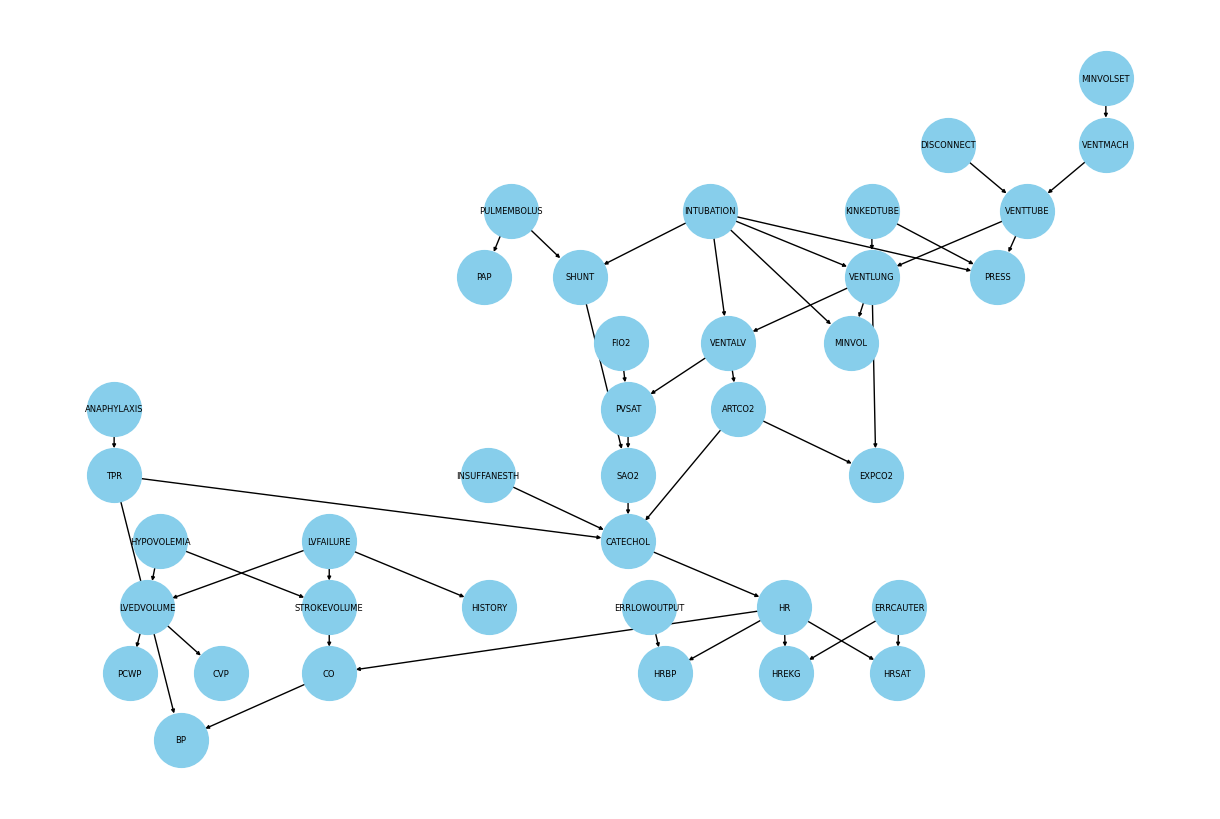

In [12]:
metrics.draw_network(ground_bn)

In [14]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [15]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [16]:
target = "HR"

X = dataset.drop(target, axis = 1).to_numpy()
y = dataset[target].to_numpy()
    
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = True
)

input_shape = len(X_train[0])
n_classes = len(dataset[target].unique())

In [17]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)
    
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

LabelEncoder()

In [18]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

In [19]:
wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")
    
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)
    
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
config.target = target
    
model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks = [WandbMetricsLogger()])
model.summary()

wandb.finish()

2025-09-29 14:59:32.136977: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7361 - loss: 0.6631 - val_accuracy: 0.8111 - val_loss: 0.5686
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.5487 - val_accuracy: 0.8111 - val_loss: 0.4956
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.4628 - val_accuracy: 0.8111 - val_loss: 0.3851
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8139 - loss: 0.3213 - val_accuracy: 0.8111 - val_loss: 0.2538
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9111 - loss: 0.2261 - val_accuracy: 0.9444 - val_loss: 0.1751
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9542 - loss: 0.1610 - val_accuracy: 0.9389 - val_loss: 0.1949
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9500 - loss: 0.1584 - val_accuracy: 0.9500 - val_loss: 0.1390
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.1229 - val_accuracy: 0.9556 - val_loss

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,118 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 49)             │         1,323 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 37)             │         1,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,713 (61.38 KB)

 Trainable params: 5,237 (20.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,476 (40.93 KB)

epoch/accuracy,▁▃▃▃▆▇▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▇▆▇▇▇▇▇▇████▇██▇███▇▇
epoch/val_loss,█▇▅▃▂▂▂▂▂▂▂▂▁▁▁▁▃▁▁▂▁▁▁▂▂
epoch/accuracy,0.97778
epoch/epoch,24
epoch/learning_rate,0.01
epoch/loss,0.07444
epoch/val_accuracy,0.96111


In [20]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

0.97

#### BAYESIAN NETWORKS AND STUFF

In [22]:
explainer = explainer.Explainer(model)
x = X[np.random.randint(len(X))]

In [31]:
x_cols = dataset.drop(target, axis = 1).columns
y_col = target

explainer.explain(x, X_train, feature_encoder, x_cols, y_col, 1000, 0.05)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INSUFFANESTH': 'C', 'VENTALV': 'C', 'INTUBATION': 'C', 'LVFAILURE': 'C', 'VENTLUNG': 'C', 'MINVOL': 'C', 'VENTMACH': 'C', 'SHUNT': 'C', 'CVP': 'C', 'VENTTUBE': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'STROKEVOLUME': 'C', 'SAO2': 'C', 'LVEDVOLUME': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'HRBP': 'C', 'HR': 'C', 'ERRCAUTER': 'C', 'BP': 'C', 'TPR': 'C', 'ERRLOWOUTPUT': 'C', 'PCWP': 'C', 'PRESS': 'C', 'DISCONNECT': 'C', 'CO': 'C', 'PVSAT': 'C', 'KINKEDTUBE': 'C', 'HRSAT': 'C', 'MINVOLSET': 'C', 'HISTORY': 'C', 'ARTCO2': 'C', 'HYPOVOLEMIA': 'C', 'ANAPHYLAXIS': 'C', 'FIO2': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INSUFFANESTH': 'C', 'VENTALV': 'C', 'INTUBATION': 'C', 'LVFAILURE': 'C', 'VENTLUNG': 'C', 'MINVOL': 'C', 'VENTMACH': 'C', 'SHUNT': 'C', 'CVP': 'C', 'VENTTUBE': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'STROKEVOLUME

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
len(explainer.data.loc[explainer.data['HR'] == '0'])

157

Ground Markov Blanket: ['CO', 'HRSAT', 'CATECHOL', 'HRBP', 'ERRCAUTER', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HREKG'] 

Explainer Markov Blanket: ['CO', 'HRSAT', 'CATECHOL', 'HRBP', 'ERRCAUTER', 'STROKEVOLUME', 'HYPOVOLEMIA', 'ERRLOWOUTPUT', 'HREKG'] 

Markov Blanket Accuracy: 9 / 10
Ground Markov Blanket: 



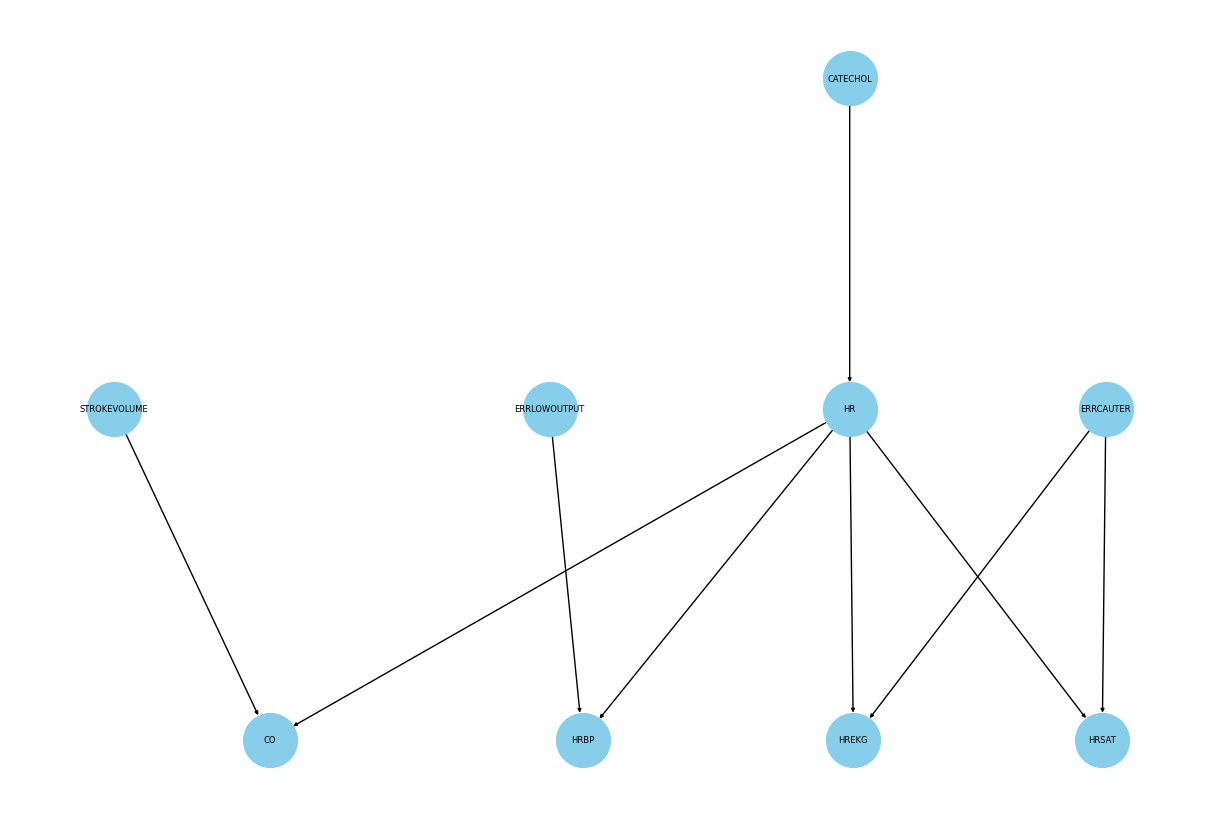

Explainer Markov Blanket: 



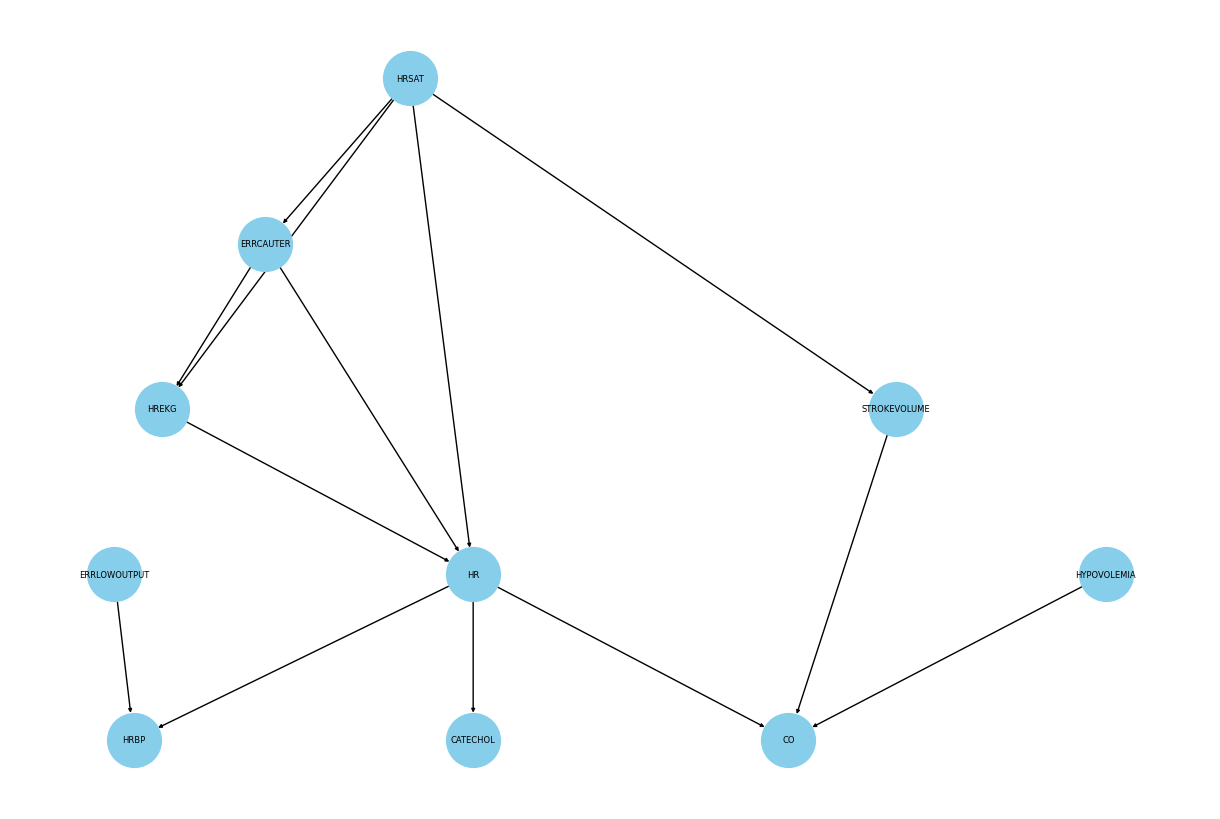

In [33]:
metrics.metrics(ground_bn, explainer.bn, 'HR')